# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

### MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [ ]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

D:\Programs\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Show(nn.Module):
    def __init__(self, *args):
        super(Show, self).__init__()
        self.shape = args

    def forward(self, x):
        print(x.shape)
        return x

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm2d(32),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Flatten(),
    nn.Linear(1600, 10),
    nn.LogSoftmax(dim=1)
)

In [ ]:
# model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()

In [ ]:
train_losses = []
accuracy_test = []
for epoch in range(10):
    for X, y in train:

        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        
        optimizer.step()
    acc_test = accuracy(model, val)
    accuracy_test.append(acc_test)
    print(f"train: {accuracy(model, train)} test: {acc_test}")

train: 0.9800333333333333 test: 0.9796
train: 0.9838833333333333 test: 0.9826
train: 0.9880833333333333 test: 0.9864
train: 0.9878333333333333 test: 0.9844
train: 0.9887666666666667 test: 0.9873
train: 0.9865666666666667 test: 0.9814
train: 0.9896666666666667 test: 0.9866
train: 0.9893166666666666 test: 0.9853
train: 0.9888333333333333 test: 0.9843
train: 0.9926166666666667 test: 0.9868


In [ ]:
print(f"max: {np.max(accuracy_test)}  mean: {np.mean(accuracy_test)}")

max: 0.9873  mean: 0.98447


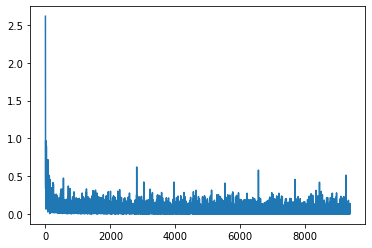

In [ ]:
plt.plot(train_losses)
plt.show()

## Реализовать морфинг автоэнкодером 
без формальных критериев — просто получите красивую гифку.

In [2]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import Video, display
import ffmpy
import numpy as np

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            Reshape(-1, 1, 28, 28),
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 32, 5),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(10, 100),
            Reshape(-1, 4, 5, 5),
            nn.Upsample(9),
            nn.Conv2d(4, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(288, 28 * 28),
            # Reshape(-1, 1, 28, 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        # data = data.cuda()
        data = data.view(-1, 784)
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d: loss %.4f' % (epoch, train_loss / len(train)))

epoch 0: loss 0.0286
epoch 1: loss 0.0197
epoch 2: loss 0.0181
epoch 3: loss 0.0172
epoch 4: loss 0.0166
epoch 5: loss 0.0162
epoch 6: loss 0.0159
epoch 7: loss 0.0157
epoch 8: loss 0.0154
epoch 9: loss 0.0152


In [376]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay, file_name='plot_morph.mp4'):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a * (1 - t) + b * t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])

    ani = animation.ArtistAnimation(fig, images, interval=delay)
    FFwriter = animation.FFMpegWriter(fps=20)
    ani.save(file_name, writer=FFwriter)

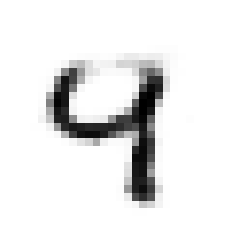

In [377]:
morph(np.random.randint(0, len(train.dataset), 30), 20, 30)

In [3]:
display(Video('plot_morph.mp4'))  

## Визуализировать MNIST автоэнкодером 
(обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

In [378]:
device = torch.device("cuda:0")

In [379]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, 2),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder().to(device)
criterion = torch.nn.L1Loss()       # я пробовала MSE, но результат на MAE мне нравился больше
optimizer = torch.optim.Adam(model.parameters())

In [380]:
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        data = data.cuda()
        data = data.view(-1, 784)
        # initial = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        # print(initial.shape, reconstructed.shape)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d: loss %.4f' % (epoch, train_loss / len(train)))

epoch 0: loss 0.1165
epoch 1: loss 0.0992
epoch 2: loss 0.0952
epoch 3: loss 0.0926
epoch 4: loss 0.0907
epoch 5: loss 0.0892
epoch 6: loss 0.0882
epoch 7: loss 0.0874
epoch 8: loss 0.0868
epoch 9: loss 0.0862
epoch 10: loss 0.0857
epoch 11: loss 0.0852
epoch 12: loss 0.0846
epoch 13: loss 0.0843
epoch 14: loss 0.0839
epoch 15: loss 0.0836
epoch 16: loss 0.0833
epoch 17: loss 0.0830
epoch 18: loss 0.0827
epoch 19: loss 0.0823


In [381]:
x = []
y = []

for data, res in train:
    data = data.cuda()
    data = data.view(-1, 784)
    x += model.encode(data).data.tolist()
    y += res.data.tolist()

In [382]:
x = np.array(x).T
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


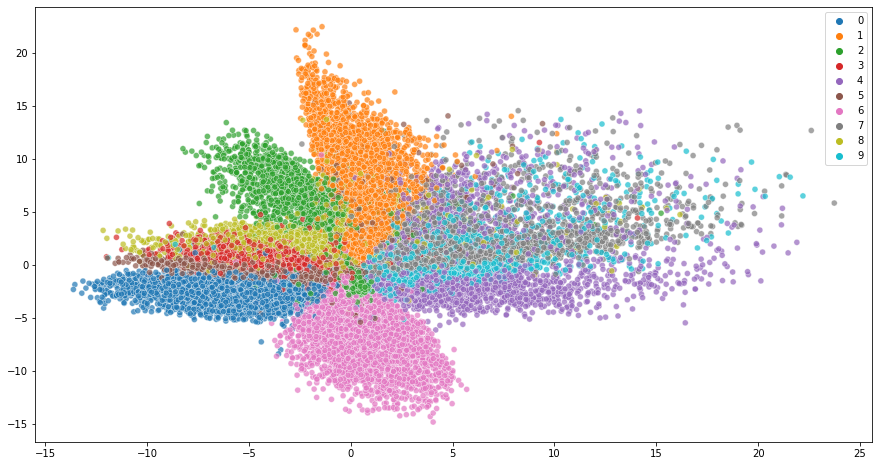

In [383]:
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.scatterplot(x[0], x[1], hue=y, alpha=0.7, palette='tab10')
plt.show()

Точки разделились не так сильно, но все-таки различия видны. Можно даже заметить, что, например, 3, 8 и 5 рядом - модель, а может и человек действительно может перепутать их написание. 